# Imports and setup 

In [1]:
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Annotated, List, Dict, TypedDict, Any
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain.pydantic_v1 import BaseModel, Field
from langchain_community.tools.tavily_search import TavilySearchResults
from tavily import TavilyClient
from langchain_core.prompts import(
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder
)
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
import functools
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from IPython.display import Image, display
from datetime import datetime
import traceback
import json
import os 
import re
import spacy

C:\Users\Kit\PycharmProjects\SEO_AI\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
os.environ["OPENAI_API_KEY"] = " "
os.environ["ANTHROPIC_API_KEY"] = " "
os.environ["TAVILY_API_KEY"] = " "

# Initialising models 

In [3]:
gpt4o_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.35)
claude_sonnet = ChatAnthropic(model="claude-3-5-sonnet-20241022")
gpt4o_model_strict = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

# Initialising the agent state

In [4]:
class AgentState(TypedDict):
    topic: str  # user input
    seo_data: Any
    
    stats: Any # actual tavily search result
    relevant_data_stats: Any # yes/no
    stats_review: Any # Why data isnt enough or relevant feedback 
    
    located_quotes: Any # 1. generated queries 2. actual returned search data
    relevant_data_quotes: Any # yes/no
    quotes_review: Any # Why data isnt enough or relevant feedback 
    stats_raw_content: Any
    extracted_quotes: Any
    
    topic_search: Any # 1. generated queries 2. actual returned search data
    topic_data_all: Any
    relevant_data_topicsearch: Any # yes/no
    topic_search_review: Any # Why data isnt enough or relevant feedback 

    research_summary: Any
    seo_data: Any

    writing_examples: Any # Place holder for user input of writing styles 
    writing_plan: Any
    writing_style: Any # make sure that the current workflow waits for this to be filled from assess writing style node
    article_plan: Any
    article: Any
    editor_notes: Any
    fact_checker_feedback: Any

    checkpointer_val: Any
    
    sender: Any
    messages: Annotated[list, operator.add]

# Setting tools 
## Grading function

In [5]:
class Gradequestion(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


system = """You are a grader assessing if there is enough relevant data related to the task provided. \n 
    It does not need to be a stringent test. The goal is to ensure that there is useful data so that we can later generate an article. \n
    If the user data provides enough information to help you output draft an article, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Data : {data}"),
    ]
)

structured_llm_grader = gpt4o_model.with_structured_output(Gradequestion)


query_grader = grade_prompt | structured_llm_grader


# Decide to continue functions 
def decide_to_continue_topic(state):
    """
    Determines whether to generate an answer, or ask an additional question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    enough_context = state["relevant_data_topicsearch"]
    print(enough_context)
        
    if enough_context == []:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: QUERY DOES NOT PROVIDE ENOUGH CONTEXT ---"
        )
        return "review_node_topic"
    else:
        # We have relevant context, so continue to gather user requirements
        print("---DECISION: GATHER REQUIREMENTS---")
        return "checkpointer"


def decide_to_continue_stats(state):
    """
    Determines whether to generate an answer, or ask an additional question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    enough_context = state["relevant_data_stats"]
    print(enough_context)
        
    if enough_context == []:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: QUERY DOES NOT PROVIDE ENOUGH CONTEXT ---"
        )
        return "review_node_stats"
    else:
        # We have relevant context, so continue to gather user requirements
        print("---DECISION: GATHER REQUIREMENTS---")
        return "checkpointer"



# def decide_to_continue_quotes(state):
#     """
#     Determines whether to generate an answer, or ask an additional question.

#     Args:
#         state (dict): The current graph state

#     Returns:
#         str: Binary decision for next node to call
#     """

#     print("---ASSESS GRADED DOCUMENTS---")
#     enough_context = state["relevant_data_quotes"]
#     print(enough_context)
        
#     if enough_context == []:
#         # All documents have been filtered check_relevance
#         # We will re-generate a new query
#         print(
#             "---DECISION: QUERY DOES NOT PROVIDE ENOUGH CONTEXT ---"
#         )
#         return "review_node_quotes"
#     else:
#         # We have relevant context, so continue to gather user requirements
#         print("---DECISION: GATHER REQUIREMENTS---")
#         return "draft_article_node"







# Desicion nodes
def descision_node_topic(state):
    """
    Determines whether the data provided is relevant to the topic and task.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK QUERY ENOUGH TO ANSWER QUESTION--")
    data = state["topic_search"]

    enough_context = []

    score = query_grader.invoke(
        {"data": data}
    )
    grade = score.binary_score
    if grade == "yes":
        print("---GRADE: QUESTION RELEVANT---")
        enough_context.append(grade)
    else:
        print("---GRADE: QUESTION NOT RELEVANT---")
    print(f"THIS WAS THE GRADE {grade}")
    return {"relevant_data_topicsearch": enough_context}



def descision_node_stats(state):
    """
    Determines whether the data provided is relevant to the topic and task.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK QUERY ENOUGH TO ANSWER QUESTION--")
    data = state["stats"]

    enough_context = []

    score = query_grader.invoke(
        {"data": data}
    )
    grade = score.binary_score
    if grade == "yes":
        print("---GRADE: QUESTION RELEVANT---")
        enough_context.append(grade)
    else:
        print("---GRADE: QUESTION NOT RELEVANT---")
    print(f"THIS WAS THE GRADE {grade}")
    return {"relevant_data_stats": enough_context}



# def descision_node_quotes(state):
#     """
#     Determines whether the data provided is relevant to the topic and task.

#     Args:
#         state (dict): The current graph state

#     Returns:
#         state (dict): Updates documents key with only filtered relevant documents
#     """

#     print("---CHECK QUERY ENOUGH TO ANSWER QUESTION--")
#     data = state["quotes"]

#     enough_context = []

#     score = query_grader.invoke(
#         {"data": data}
#     )
#     grade = score.binary_score
#     if grade == "yes":
#         print("---GRADE: QUESTION RELEVANT---")
#         enough_context.append(grade)
#     else:
#         print("---GRADE: QUESTION NOT RELEVANT---")
#     print(f"THIS WAS THE GRADE {grade}")
#     return {"relevant_data_quotes": enough_context}

# Setting tools
## Search tools 

In [6]:
class Queries(BaseModel):
    queries: List[str]

# search_engine = DuckDuckGoSearchAPIWrapper()


@tool
def search_engine_topic(topic_search: Queries):
    """Search engine to the internet."""

    aggregate_search = []

    for q in topic_search.queries:
    
        print(f"Query: {q}")
        results = DuckDuckGoSearchAPIWrapper()._ddgs_text(q)
        aggregate_search.append(results)
    
    return {"topic_search": aggregate_search}

# @tool
# def search_engine_quotes(quotes: Queries):
#     """Search engine to the internet."""
#     aggregate_search = []

#     for q in quotes.queries:
    
#         print(f"Query: {q}")
#         results = DuckDuckGoSearchAPIWrapper()._ddgs_text(q)
#         aggregate_search.append(results)
#     return {"quotes": aggregate_search}



def clean_text(raw_text: str) -> str:
    """
    Improved text cleaning function with None handling.
    """
    if raw_text is None:
        return ""
        
    if not isinstance(raw_text, str):
        return str(raw_text)
    
    # Remove HTML tags if present
    text = re.sub(r'<[^>]+>', ' ', raw_text)
    
    # Normalize apostrophes and quotes
    text = text.replace(''', "'").replace(''', "'")
    text = text.replace('"', '"').replace('"', '"')
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()


#fix this 

def clean_speaker(speaker: str) -> str:
    """Clean up speaker attribution"""
    if not speaker:
        return None
        
    # Remove common prefixes
    prefixes_to_remove = [
        'according to',
        'as noted by',
        'as stated by',
        'as reported by',
        'as mentioned by',
        "if you'd",
        'as'
    ]
    
    speaker = speaker.lower()
    for prefix in prefixes_to_remove:
        if speaker.startswith(prefix):
            speaker = speaker[len(prefix):].strip()
    
    # Clean up common patterns
    speaker = re.sub(r'^(a|the)\s+', '', speaker)
    speaker = speaker.strip('," ')
    
    # Validate speaker
    if len(speaker) < 2 or speaker in ['if', 'as', 'the', 'a']:
        return None
        
    return speaker.strip()

def is_complete_sentence(text: str) -> bool:
    """Check if text appears to be a complete sentence"""
    if not text:
        return False
        
    # Should end with sentence-ending punctuation
    if not text.rstrip()[-1] in '.!?':
        return False
        
    # Should not end with an abbreviation (e.g., "U.S." or "etc.")
    if re.search(r'\b[A-Za-z]{1,3}\.$', text):
        return False
        
    # Should have reasonable length
    words = text.split()
    if len(words) < 5:
        return False
        
    return True

def extract_full_quote(text: str, partial_quote: str) -> str:
    """Try to extract the complete quote if it was cut off"""
    if is_complete_sentence(partial_quote):
        return partial_quote
        
    # Find where the partial quote appears in the text
    start_idx = text.find(partial_quote)
    if start_idx == -1:
        return partial_quote
        
    # Look ahead for the end of the sentence
    end_idx = start_idx + len(partial_quote)
    while end_idx < len(text) and text[end_idx] not in '.!?':
        end_idx += 1
    if end_idx < len(text):
        end_idx += 1
        
    return text[start_idx:end_idx].strip()

def process_quotes(state):
    """
    Extract quotes with improved accuracy and deduplication
    """
    quote_results = []
    seen_quotes = set()  # For deduplication
    
    all_sources = {
        **state.get("stats_raw_content", {}),
        **state.get("topic_data_all", {})
    }
    
    # Patterns for different quote types
    personal_pattern = (
        r'([^.!?]*?)'  # Capture everything before the verb
        r'(said|says|told|stated|explained|noted|added|commented|mentioned|'
        r'claimed|announced|declared|suggested|responded|replied|concluded)'  # The verb
        r'\s+([^.!?]+?[.!?])'  # Capture everything after until the end of sentence
    )
    
    research_pattern = (
        r'according to (?:a |the )?'
        r'(?P<source>'
        r'(?:survey|study|report|research|data|statistics|analysis|estimates'
        r'|market research|available data|market data)'
        r'[^.!?]*?)'  # Capture source details
        r',?\s*'
        r'(?P<statement>[^.!?]+?[.!?])'  # Capture the statement
    )
    
    for url, raw_text in all_sources.items():
        if not raw_text:
            continue
            
        clean_content = clean_text(raw_text)
        
        # Process personal quotes
        for match in re.finditer(personal_pattern, clean_content, re.IGNORECASE):
            try:
                before_verb = match.group(1).strip()
                verb = match.group(2).strip()
                quote = match.group(3).strip()
                
                # Clean and validate speaker
                speaker = clean_speaker(before_verb)
                if not speaker:
                    continue
                
                # Get complete quote if needed
                full_quote = extract_full_quote(clean_content, quote)
                
                # Skip if we've seen this quote
                quote_key = (full_quote.lower(), speaker.lower())
                if quote_key in seen_quotes:
                    continue
                
                if is_complete_sentence(full_quote):
                    quote_results.append({
                        'quote': full_quote,
                        'speaker': speaker,
                        'context': f"{before_verb} {verb} {full_quote}",
                        'confidence': 0.9,
                        'source_url': url
                    })
                    seen_quotes.add(quote_key)
            
            except Exception as e:
                continue
        
        # Process research quotes
        for match in re.finditer(research_pattern, clean_content, re.IGNORECASE):
            try:
                source = match.group('source').strip()
                statement = match.group('statement').strip()
                
                # Clean source
                clean_source = clean_speaker(source)
                if not clean_source:
                    continue
                
                # Get complete statement if needed
                full_statement = extract_full_quote(clean_content, statement)
                
                # Skip if we've seen this quote
                quote_key = (full_statement.lower(), clean_source.lower())
                if quote_key in seen_quotes:
                    continue
                
                if is_complete_sentence(full_statement):
                    quote_results.append({
                        'quote': full_statement,
                        'speaker': clean_source,
                        'context': f"According to {source}, {full_statement}",
                        'confidence': 0.8,
                        'type': 'research',
                        'source_url': url
                    })
                    seen_quotes.add(quote_key)
            
            except Exception as e:
                continue
    
    # Sort by confidence
    quote_results.sort(key=lambda x: x['confidence'], reverse=True)
    
    return {"located_quotes": quote_results}
# Agentic QA
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

# Setting Nodes
## Review Nodes

In [7]:
def review_node_topic():
    messages = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="You are an expert researcher. Your task is to review the research collected on the topic provided and answer why the data included is not enough or not relevant to our topic. You must first read the data collected, Then output your thoughts on how it could be improved in terms of what else should be collected."),
        HumanMessage(content=f"Topic: {state['topic']}")
    ])
    return {"topic_search_review": messages.content}

def review_node_stats():
    messages = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="You are an expert researcher.Your task is to review the research collected on the statistics about the topic we are researching. You must provide an answer to why the data included is not enough or not relevant to our task of getting quotes about the topic. You must first read the data collected, Then output your thoughts on how it could be improved in terms of what else should be collected."),
        HumanMessage(content=f"Topic: {state['topic']}, Topic specific task: Stats data, data colletected: {state["stats"]}")
    ])
    return {"stats_review": messages.content}

# def review_node_quotes():
#     messages = gpt4o_model.with_structured_output(Queries).invoke([
#         SystemMessage(content="You are an expert researcher. Your task is to review the research collected on the quotes about the topic we are researching. You must provide an answer to why the data included is not enough or not relevant to our task of getting quotes about the topic. You must first read the data collected, Then output your thoughts on how it could be improved in terms of what else should be collected."),
#         HumanMessage(content=f"Topic: {state['topic']}, Topic specific task: quotes data, data collected: {state["quotes"]}")
#     ])
#     return {"quotes_review": messages.content}
    

# Setting nodes
## Main search Nodes

In [8]:
# This is okay could be improved. 
def researchq_topic_node(state: AgentState):

    raw_content = {}
    content = []
    queries = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="You are an expert researcher. Your task is to collect general research on the topic provided, this could be about the market, general industry trends ect. You will output a search query based on the relevant topic to collect this data. Please only output 3 queries"),
        HumanMessage(content=f"Topic: {state['topic']}, feedback on previous collected data: {state["topic_search_review"]}")
    ])

    content = state['topic_search'] or []
    for q in queries.queries:
        print(f"reaserch topic node query: {q}")
        response = tavily.search(query=q, max_results=3, include_raw_content=True)
        for r in response['results']:
            content.append([r["content"], r["url"]])
            raw_content[r["url"]] = r["raw_content"]
    return {"topic_search": content, "topic_data_all": raw_content}


# This is good and returning relevant information. This is not a researchq because it is actually returning the data within it. 
def research_stats_node(state: AgentState):

    raw_content = {}
    content = []
    queries = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="You are an expert researcher. Your task is to collect statistics and other data on the topic provided. You will do this by generating a search query based on the topic the user has provided. Please generate 3 queries."),
        HumanMessage(content=f"Topic: {state['topic']}, feedback on previous collected data: {state["stats_review"]}")
    ])
    content = state['stats'] or []
    for q in queries.queries:
        print(f"reaserch stats node query: {q}")
        response = tavily.search(query=q, max_results=3, include_raw_content=True)
        for r in response['results']:
            content.append([r["content"], r["url"]])
            raw_content[r["url"]] = r["raw_content"]
    return {"stats": content, "stats_raw_content": raw_content}



# def researchq_quotes_node(state: AgentState):
#     queries = gpt4o_model.with_structured_output(Queries).invoke([
#         SystemMessage(content="We are creating an article based on a certain topic. In order for us to do this we need to find quotes on this topic. You will be given the topic. Your task is to output a search query to find quotes based on that topic. This is so that we can find relevant data. Please only output 2 queries"),
#         HumanMessage(content=f"Topic: {state['topic']}, feedback on previous collected data: {state["quotes_review"]}")
#     ])

#     print(f"Try this?: {queries}")
#     return {"quotes": queries}


In [9]:
# check point function 

def checkpointer(state):
    print("Waiting for both functions to complete")
    return {"checkpointer_val": "waiting"}

# Synchronization check function
def check_completion(state):
    # Check if both branches have produced results
    if state["relevant_data_stats"] and state["relevant_data_topicsearch"] != []:
        print(type(state["relevant_data_stats"]))
        print(type(state["relevant_data_topicsearch"]))
        return "READY"
    return "WAIT"

In [10]:
# Continued workflow

# Content writing workflow

In [11]:
class EditorCheck(BaseModel):

    approval: str = Field(
        description="do any edits need to be made to the article? 'yes' or 'no' "
    )
    feedback: str = Field(
        description= "What improvements need to be made to the article? If no improvements need to be made, why?"
    )
    

In [12]:
system = """You are an exper editor grading if the article written has been approved. \n 
    It does not need to be a stringent test. You will be given feedback from the editor and must use this to provide your answer \n
    In order to preform this task well you must follow these 3 steps:\n
    1. read the feedback from the editor
    2. decide weather the article has been given approval, score this 'yes' or 'no'
    3. Provide the feedback that was given from the editor. """

editor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "editor : {editor_remarks}"),
    ]
)

editor_llm = gpt4o_model.with_structured_output(EditorCheck)


editor_grader = editor_prompt | editor_llm

In [38]:
def has_gained_editor_approval(state):
    """
    Determines whether to generate an answer, or ask an additional question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    editor_feedback = state["editor_notes"]
    print(editor_feedback)
        
    if editor_feedback.approval == 'no':
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ARTICLE NEEDS TO BE REWRITTEN ---"
        )
        return "writer_node"
    else:
        # We have relevant context, so continue to gather user requirements
        print("---DECISION: ARTICLE HAS PASSED EDITOR CHECKS ---")
        return "fact_checker_node"


In [39]:
def get_relevant_quotes_in_data(state: AgentState):

    quotes = state["located_quotes"]
    messages = claude_sonnet.invoke([
        SystemMessage(content=""" Your task is to review this collection of quotes from the market research team. Your job is very important. You must output only the relevant quotes and sources. If the quote is not actually a quote do not output it. If the quote is a quote but it is messy, please clean it.
                                    In order for a quote to be relevant we need: the actual quote, who said the quote and the url where the quote came from.
                                    In order to do this task well follow these steps:
                                    step 1. Read all the quotes
                                    step 2. reason why you may need to omit some of the quotes and why you need to keep some of the quotes
                                    step 3. output the clean selected quotes and sources."""),
        HumanMessage(content=f" Collected data: {state["located_quotes"]}")
    ])
        
    return {"extracted_quotes":messages.content}

In [40]:
def market_reaserch_summary(state):
    stats = state["stats"]
    topic_search = state["topic_search"]
    topic = ["topic"]
    messages = claude_sonnet.invoke([
        SystemMessage(content=""" Your task is to review this collection of data from the market research team. Your task is to create a comprehensive market research summary selecting the most relevant statistics and data. This should give an overview of our research.
                                    step 1. Review all the data
                                    step 2. describe your observations
                                    step 3. output the market research summary."""),
        HumanMessage(content=f"Topic: {topic} Collected data: {topic_search}, stats: {stats}")
    ])
        
    return {"research_summary":messages.content}

In [48]:
def assess_writing_style(state: AgentState):
    messages = claude_sonnet.invoke([
        SystemMessage(content="""You are an expert writer. Your task is to review the examples given to you and describe their writing style. \n 
        This is so that later we can try write an article in a similar style to these examples.
        In order to do this task well you must describe the writing style in terms of: \n 
        1. Tone \n 
        2. word choice \n 
        3. Sentence structure \n """),
        HumanMessage(content=f"Examples: ###{state['writing_examples']}###")
    ])
    return {"writing_style": messages.content}

def draft_article_node(state: AgentState):
    messages = claude_sonnet.invoke([
        SystemMessage(content="""You are an expert writer. You will be given a topic, the writing style and some data. Your task is to create a writing plan using this information. This should be able to guide your writers to create an article. \n
                                 In order to do this task well you must follow these steps: \n 
                                    1. Read the topic, writing style and data \n 
                                    2. make observations about how you should approach this task \n 
                                    3. Output a writing plan for this article. """),
        HumanMessage(content=f"Topic: {state['topic']}, collected data: {state["topic_search"]}")
    ])
    return {"article_plan": messages.content}




def writer_node(state: AgentState):

    editor_notes = state["editor_notes"]
    try:
        feedback = editor_notes.feedback
    except:
        print("no feedback from editor")

    if editor_notes.approval == "no":
        print("editor requires another draft")
        sys_prompt = """You are an expert writer. Your task is to write an article in a specific style. \n 
        You will be given a description of the writing style to write in and some examples of that writing style. \n 
        You will also be given some research that your researchers have collected, which includes some content and their corresponding URLs. \n  
        this data must be included in the article. You must cite the source of this data in the article using the correct URL. \n 
        Your editor has suggested some feedback to improve the article. This will be given to you delimited in the triple brackets. \n 
        When making your edits please continue to write the article in a similar style. You will be given the article. \n 
        \n 
        The format for how this data will be given to you is as follows:\n 
        \n 
        TOPIC: !!! topic !!! \n  
        MARKET RESEARCH REPORT: /// market research summary /// \n 
        FEEDBACK: [[[feedback from editor]]] """

        msg_prompt = f"""TOPIC: !!!{state['topic']}!!!  
        MARKET RESEARCH REPORT /// {state["research_summary"]} ///
        ARTICLE ### {state["article"]} ### 
        FEEDBACK: [[[{state["extracted_quotes"]}]]]"""

        messages = claude_sonnet.invoke([
        SystemMessage(content=sys_prompt),
        HumanMessage(content=msg_prompt)
    ])
        return {"article": messages.content}

    
    else: 
        sys_prompt = """You are an expert writer. Your task is to write an article in a specific style. \n 
        You will be given a description of the writing style to write in and some examples of that writing style. \n 
        You will also be given some research that your researchers have collected, which includes some content and their corresponding URLs. \n  
        this data must be included in the article. You must cite the source of this data in the article using the correct URL. \n 
        You will also be given some quotes to use. If you decide to use a quote, you must cite the source and who said it. this also includes adding the correct URL to that source \n 
        Because our editor would like this written in a certain style, you will also be given some extracts of previous articles with the writing style to match.
        \n 
        The format for how this data will be given to you is as follows:\n 
        \n 
        TOPIC: !!! topic !!! \n 
        WRITING PLAN: ### writing plan ### \n 
        WRITING EXAMPLES: <<< writing examples >>> \n 
        MARKET RESEARCH REPORT: /// market research summary /// \n 
        QUOTES: [[[quotes]]] """

        msg_prompt = f"""TOPIC: !!!{state['topic']}!!! 
        WRITING PLAN: ### {state['article_plan']} ### \n 
        WRITING EXAMPLES: <<< {state['writing_examples']} >>>
        MARKET RESEARCH REPORT /// {state["research_summary"]} ///
        QUOTES: [[[{state["extracted_quotes"]}]]]"""

        messages = claude_sonnet.invoke([
        SystemMessage(content=sys_prompt),
        HumanMessage(content=msg_prompt)
    ])
    
        return {"article": messages.content}

def seo_injection_node(state: AgentState):
    messages = gpt4o_model.invoke([
        SystemMessage(content="""You are an expert writer. Your task is to review the article to inject some SEO keywords into it.\n 
        You will be given a list of SEO keywords. You must not change the information in the article, only replace words for our SEO keywords so that the article still reads well and makes sense.\n 
        You must output the article in full with the new changes. You may not be able to use all the keywords and that is okay. Just place the ones in that are relevant and still make sense within the article.
        You must not remove any of the urls as this is important for our citation."""),
        HumanMessage(content=f"SEO Keywords: ###{state['seo_data']}###, Article: {state['article']}")
    ])
    return {"article": messages.content}

def editor_node(state: AgentState):
    messages = claude_sonnet.invoke([
        SystemMessage(content="""You are an expert editor. Your task is to review the article given to you and ensure that it has followed this checklist. \n 
        In order to do this task follow these steps: \n 
        1. Read the article \n 
        2. read the writing plan and review the writing examples \n 
        3. Write your feedback as to whether the article has been written correctly \n """),
        HumanMessage(content=f"""ARTICLE: !!!{state['article']}!!! 
        WRITING PLAN: ### {state['article_plan']} ### \n 
        WRITING EXAMPLES: <<< {state['writing_examples']} >>> 
        MARKET RESEARCH REPORT /// {state["research_summary"]} ///
        QUOTES: [[[{state["extracted_quotes"]}]]] """)
    ])

    editor_feedback = editor_grader.invoke(messages)
    
    return {"editor_notes": editor_feedback}

def fact_checker_node(state: AgentState):
    messages = gpt4o_model.invoke([
        SystemMessage(content="""You are an expert editor. Your task is to review the article given to you and ensure that it has incooperated the research and correctly cited its sources. You will be checking the research itself and the quotes. \n 
        In order to do this task follow these steps: \n 
        1. Read the article \n 
        2. read the writing plan and review the writing examples \n 
        3. Write your feedback as to whether the article has been written correctly \n """),
        HumanMessage(content=f"""ARTICLE: !!!{state['article']}!!! 
        MARKET RESEARCH: ### {state['research_summary']} ### 
        QUOTES: [[[{state["extracted_quotes"]}]]]""")
    ])
    return {"fact_checker_feedback": messages.content}



In [49]:
workflow = StateGraph(AgentState)

In [50]:

# Query generating nodes (stats currently returns search results)
workflow.add_node(researchq_topic_node, "researchq_topic_node")
workflow.add_node(research_stats_node, "research_stats_node")

# Tool nodes to search for results
workflow.add_node(process_quotes, "process_quotes")
workflow.add_node(get_relevant_quotes_in_data, "get_relevant_quotes_in_data")

# Asses weather data is relevant nodes
workflow.add_node(descision_node_topic, "descision_node_topic")
workflow.add_node(descision_node_stats, "descision_node_stats")

# Decide weather to continue or not nodes (actually a function)

# Review nodes 
workflow.add_node(review_node_topic, "review_node_topic")
workflow.add_node(review_node_stats, "review_node_stats")
# workflow.add_node(review_node_quotes, "review_node_quotes")


workflow.add_node(checkpointer, "checkpointer")
workflow.add_node(market_reaserch_summary, "market_reaserch_summary")

workflow.add_node(assess_writing_style, "assess_writing_style")
workflow.add_node(draft_article_node, "draft_article_node")
workflow.add_node(writer_node, "writer_node")
workflow.add_node(seo_injection_node, "seo_injection_node")
workflow.add_node(editor_node, "editor_node")
workflow.add_node(fact_checker_node, "fact_checker_node")

In [51]:
# Generate query 
workflow.add_edge(START, "researchq_topic_node")
workflow.add_edge(START, "research_stats_node")

# Assess weather data is relevant or not 
workflow.add_edge("researchq_topic_node", "descision_node_topic")
workflow.add_edge("research_stats_node", "descision_node_stats")
# workflow.add_edge("search_engine_quotes", "descision_node_quotes")


# Is the data relevant? 
workflow.add_conditional_edges(
    "descision_node_topic",
    decide_to_continue_topic ,
    {
        "review_node_topic": "review_node_topic",
        "checkpointer": "checkpointer",
    },
)


workflow.add_conditional_edges(
    "descision_node_stats",
    decide_to_continue_stats ,
    {
        "review_node_stats": "review_node_stats",
        "checkpointer": "checkpointer",
    },
)


workflow.add_conditional_edges(
    "checkpointer",
    check_completion,
    {
        "READY": "process_quotes",
        "WAIT": "checkpointer",
    },
)

# Data is not relevant, provide feedback to the query generator
workflow.add_edge("review_node_topic", "researchq_topic_node")
workflow.add_edge("review_node_stats", "research_stats_node")
# workflow.add_edge("review_node_quotes", "researchq_quotes_node")



# Data is relevant, draft article and finish 
workflow.add_edge("process_quotes", "get_relevant_quotes_in_data")
workflow.add_edge("get_relevant_quotes_in_data", "market_reaserch_summary")
workflow.add_edge("market_reaserch_summary", "assess_writing_style")
workflow.add_edge("assess_writing_style", "draft_article_node")
workflow.add_edge("draft_article_node", "writer_node")
workflow.add_edge("writer_node", "seo_injection_node")
workflow.add_edge("seo_injection_node", "editor_node")

workflow.add_conditional_edges(
    "editor_node",
    has_gained_editor_approval,
    {
        "writer_node": "writer_node",
        "fact_checker_node": "fact_checker_node",
    },
)


workflow.add_edge("fact_checker_node", END)


thread = {"configurable": {"thread_id": "1"}}

graph = workflow.compile()

# Visulise the Graph 

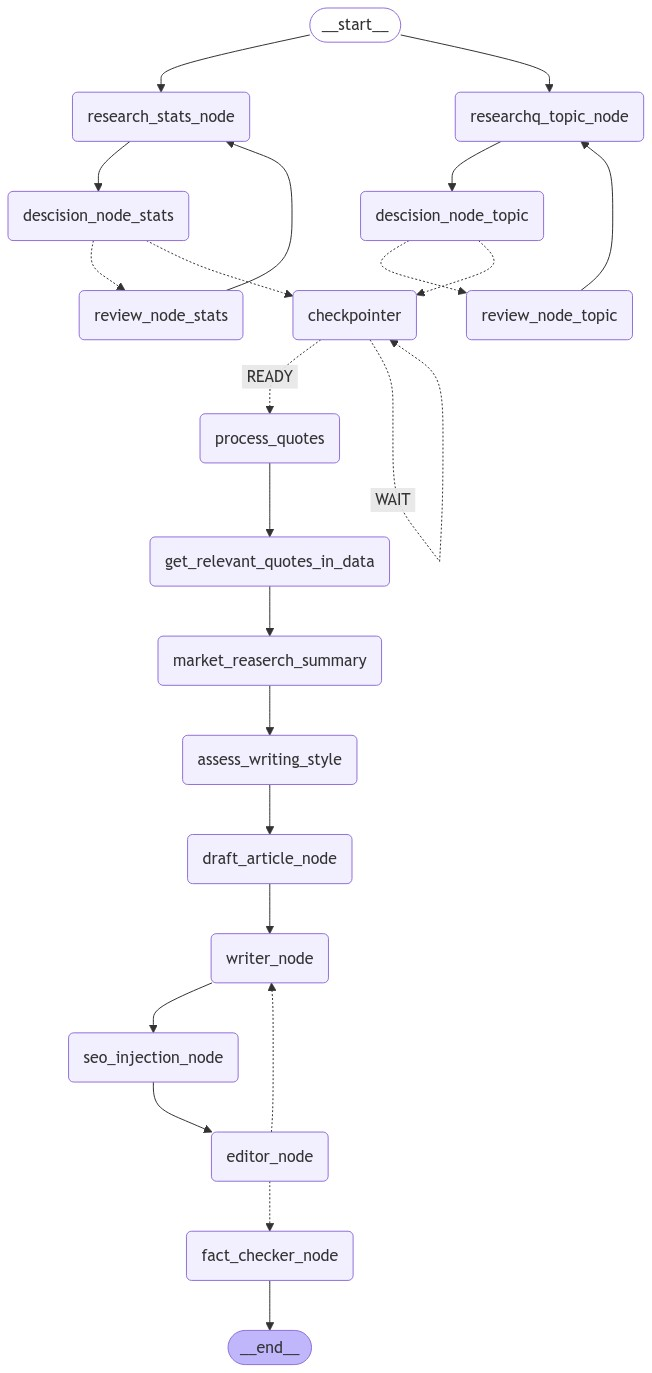

In [52]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles


display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [53]:
# !python -m spacy download en_core_web_sm
# Check how to deploy this 

In [54]:
thread = {"configurable": {"thread_id": "0"}}

graph = workflow.compile()


initialise_check = EditorCheck(
    approval="initialise",
    feedback="initialise"
)

fender_keywords = [
    # Brand and Heritage
    'Fender guitars',
    'Fender Stratocaster',
    'Fender Telecaster',
    'Fender Precision Bass',
    'Fender Jazz Bass',
    'Leo Fender',
    'Custom Shop Fender',
    
    # Popular Models
    'Fender Player Series',
    'Fender American Professional',
    'Fender American Vintage',
    'Fender Squier',
    'Fender Mexico',
    'Fender American Standard',
    
    # Technical Terms
    'Fender single-coil pickups',
    'Fender maple neck',
    'Fender alder body',
    'Fender tremolo system',
    'Fender tone woods',
    'Fender scale length',
    
    # Historical/Cultural
    'Fender history',
    'Fender California legacy',
    'Fender famous players',
    'Fender sound',
    'Fender vintage specs',
    
    # Modern Features
    'Fender Modern Player',
    'Fender custom colors',
    'Fender electronics',
    'Fender setup guide',
    'Fender specifications'
]



all_responses = []

for s in graph.stream(
        {"topic": "Fender guitars",
         "writing_examples": ["""Target High-potential Markets
Despite the general growth, the success—in terms of both user penetration and monetary returns—remains within major use cases. Research regional policies, industrial demands and future applications to adapt your strategy accordingly. In some areas, localised or residential markets can outweigh the potential of grid-scale storage, residential or commercial applications. While in other areas, you might find more potential in the large-scale storage sector. So, it's crucial to identify the market requirements to optimise your strategy.
Prioritise Technological Excellence
Given the rapid evolution of this space, innovation is the key to success. Spend a good chunk of capital on R&D and consider establishing partnerships with academic institutions to remain ahead in terms of technological advancements. Your continued presence in the industry through new product releases, patents and presence at industry events can highlight your commitment to innovation and help you catch the eye of investors.
Put Together an Experienced Team
Energy storage in and of itself is an incredibly complex subject that requires a collaboration of diverse expertise. Recruit a cadre of electrical engineers, chemists, software developers and energy market gurus. Showcase team credentials to build credibility with investors and customers.
Create a Solid Financial Plan
Create detailed financial projections that account for different market scenarios. Explore creative financing models like GM leasing or energy-as-a-service to expand your customer base. A clear path to profitability with achievable projections and goals is crucial for attracting investments.
"""],
         "writing_style": "flexible",
        "stats": [],
        "quotes": [],
        "topic_search": [],
        "topic_search_review": [],
        "stats_review": [],
        "quotes_review": [],
         "seo_data": fender_keywords,
        "editor_notes": initialise_check}
):
    if "__end__" not in s:
        print(s)
        print("----")
        all_responses.append(s)

reaserch topic node query: Fender guitars market trends 2023
reaserch stats node query: Fender guitars sales statistics 2023
reaserch topic node query: Fender guitars customer reviews and feedback
reaserch topic node query: Fender guitars sales statistics and industry analysis
{'researchq_topic_node': {'topic_search': [["From the soaring market size of the global guitar market to the ever-changing trends in guitar sales, and the rise of learning guitar through YouTube ... 2023: 3.0 billion: 2024: 3.1 billion: 2025: 3.2 billion: 2026: 3.2 billion: ... Fender's dominance in the guitar market can be attributed to a number of factors, including its reputation for", 'https://sandymusiclab.com/latest-guitar-industry-statistics-year-trends-market-size-and-sales/'], ["The data from Reverb offers insightful trends into the guitar market's dynamics. The average selling price of a Fender Stratocaster at $1,249 highlights the enduring popularity and perceived value of established brands. ... with 

In [68]:
all_responses[11]["seo_injection_node"]["article"]

'**Fender Guitars: Striking the Right Chord in a Growing Market**\n\nIn an era where traditional industries face disruption, Fender Musical Instruments Corporation continues to demonstrate remarkable resilience and growth in the global guitar market. With the industry valued at $10.95 billion in 2023 and projected to reach $18.44 billion by 2030, Fender\'s strategic positioning and market adaptability have proven crucial to its sustained success.\n\n**Optimize Market Penetration**\nFender\'s recent performance highlights its ability to capitalize on market opportunities. The company achieved an impressive 17% growth during the pandemic, with revenue expectations exceeding $700 million. This success wasn\'t merely circumstantial - it reflected broader industry trends that saw unprecedented demand across all segments, including popular models like the **Fender Stratocaster** and **Fender Telecaster**.\n\nAs Mike Clem, Sweetwater\'s Chief Digital Officer, noted, "At Sweetwater, we are see

In [69]:
class ArticleFormatter:
    def __init__(self):
        self.section_pattern = re.compile(r'\*\*(.*?)\*\*')
    
    def split_into_sections(self, text: str) -> List[str]:
        """Split the text into sections based on newlines while preserving meaningful breaks."""
        sections = [s.strip() for s in text.split('\n') if s.strip()]
        return sections
    
    def format_section(self, section: str) -> str:
        """Format individual sections with proper markdown and spacing."""
        # Check if it's a header (surrounded by asterisks)
        if section.startswith('**') and section.endswith('**'):
            # Convert to markdown header
            return f"\n## {section.strip('*')}\n"
        
        # Handle bullet points
        if section.startswith('- ') or section.strip().startswith('•'):
            return section
        
        # Handle numbered lists
        if re.match(r'^\d+\.', section):
            return section
        
        # Regular paragraph
        return section
    
    def format_article(self, text: str) -> str:
        """Format the entire article with proper spacing and markdown."""
        # Split into sections
        sections = self.split_into_sections(text)
        
        # Format each section
        formatted_sections = []
        for section in sections:
            formatted = self.format_section(section)
            formatted_sections.append(formatted)
        
        # Join sections with proper spacing
        formatted_text = '\n\n'.join(formatted_sections)
        
        # Clean up extra spaces and normalize newlines
        formatted_text = re.sub(r'\n{3,}', '\n\n', formatted_text)
        formatted_text = formatted_text.strip()
        
        return formatted_text

def format_article(text: str) -> str:
    """Convenience function to format an article."""
    formatter = ArticleFormatter()
    return formatter.format_article(text)
    
# Format the article
formatted_article = format_article(all_responses[11]["seo_injection_node"]["article"])
print(formatted_article)

## Fender Guitars: Striking the Right Chord in a Growing Market

In an era where traditional industries face disruption, Fender Musical Instruments Corporation continues to demonstrate remarkable resilience and growth in the global guitar market. With the industry valued at $10.95 billion in 2023 and projected to reach $18.44 billion by 2030, Fender's strategic positioning and market adaptability have proven crucial to its sustained success.

## Optimize Market Penetration

Fender's recent performance highlights its ability to capitalize on market opportunities. The company achieved an impressive 17% growth during the pandemic, with revenue expectations exceeding $700 million. This success wasn't merely circumstantial - it reflected broader industry trends that saw unprecedented demand across all segments, including popular models like the **Fender Stratocaster** and **Fender Telecaster**.

As Mike Clem, Sweetwater's Chief Digital Officer, noted, "At Sweetwater, we are seeing 50% to 10

In [72]:
!pip install python-docx

  Using cached lxml-5.3.0-cp312-cp312-win_amd64.whl.metadata (3.9 kB)
Using cached lxml-5.3.0-cp312-cp312-win_amd64.whl (3.8 MB)


In [73]:
article = all_responses[11]["seo_injection_node"]["article"]

In [75]:
from docx import Document
from docx.shared import Pt, Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH, WD_LINE_SPACING
from docx.enum.style import WD_STYLE_TYPE
import re

def create_formatted_word_doc(text, output_filename='Fender_Market_Analysis.docx'):
    """
    Creates a properly formatted Word document locally.
    """
    doc = Document()
    
    # Set up document styles
    styles = doc.styles
    
    # Style for main title
    title_style = styles.add_style('CustomTitle', WD_STYLE_TYPE.PARAGRAPH)
    title_style.font.size = Pt(16)
    title_style.font.bold = True
    title_style.paragraph_format.space_after = Pt(12)
    
    # Style for section headers
    header_style = styles.add_style('CustomHeader', WD_STYLE_TYPE.PARAGRAPH)
    header_style.font.size = Pt(14)
    header_style.font.bold = True
    header_style.paragraph_format.space_before = Pt(18)
    header_style.paragraph_format.space_after = Pt(12)
    
    # Style for normal paragraphs
    normal_style = styles.add_style('CustomNormal', WD_STYLE_TYPE.PARAGRAPH)
    normal_style.font.size = Pt(11)
    normal_style.paragraph_format.space_after = Pt(12)
    normal_style.paragraph_format.line_spacing_rule = WD_LINE_SPACING.SINGLE
    
    # Style for list items
    list_style = styles.add_style('CustomList', WD_STYLE_TYPE.PARAGRAPH)
    list_style.font.size = Pt(11)
    list_style.paragraph_format.space_after = Pt(12)
    list_style.paragraph_format.left_indent = Inches(0.25)
    list_style.paragraph_format.first_line_indent = Inches(0.25)
    
    # Set document margins
    sections = doc.sections
    for section in sections:
        section.left_margin = Inches(1)
        section.right_margin = Inches(1)
        section.top_margin = Inches(1)
        section.bottom_margin = Inches(1)

    def clean_header(text):
        """Remove asterisks and clean up header text"""
        return text.strip('*')
    
    def process_list_item(content):
        """Clean up list items by removing extra numbers and formatting"""
        # Remove duplicate numbers
        content = re.sub(r'^\s*\d+\.\s*\d+\.\s*', '', content)
        # Remove asterisks from the header part while preserving the text
        content = re.sub(r'\*\*(.*?)\*\*', r'\1', content, count=1)
        return content.strip()
    
    # Split text into paragraphs
    paragraphs = text.split('\n')
    in_list = False
    
    for para in paragraphs:
        para = para.strip()
        if not para:
            continue
            
        # Handle title (first bold text)
        if para.startswith('**') and para.endswith('**') and not doc.paragraphs:
            p = doc.add_paragraph(style='CustomTitle')
            p.add_run(clean_header(para))
            continue
            
        # Handle section headers
        if para.startswith('**') and para.endswith('**'):
            p = doc.add_paragraph(style='CustomHeader')
            p.add_run(clean_header(para))
            continue
            
        # Handle numbered lists
        if re.match(r'^\s*\d+\.\s*\d+\.\s*\*\*', para):
            in_list = True
            p = doc.add_paragraph(style='CustomList')
            
            # Extract and add list number
            list_num = re.match(r'^\s*(\d+)\.', para).group(1)
            p.add_run(f"{list_num}. ")
            
            # Process the content
            content = process_list_item(para)
            
            # Handle any remaining bold text in the list item
            parts = re.split(r'(\*\*.*?\*\*)', content)
            for part in parts:
                if part.startswith('**') and part.endswith('**'):
                    p.add_run(part.strip('*')).bold = True
                else:
                    p.add_run(part)
            continue
            
        # Regular paragraphs
        p = doc.add_paragraph(style='CustomNormal')
        parts = re.split(r'(\*\*.*?\*\*)', para)
        for part in parts:
            if part.startswith('**') and part.endswith('**'):
                p.add_run(part.strip('*')).bold = True
            else:
                p.add_run(part)
    
    # Save the document
    doc.save(output_filename)
    return f"Document has been created as {output_filename}"

# Create the Word document
result = create_formatted_word_doc(article)
print(article)

**Fender Guitars: Striking the Right Chord in a Growing Market**

In an era where traditional industries face disruption, Fender Musical Instruments Corporation continues to demonstrate remarkable resilience and growth in the global guitar market. With the industry valued at $10.95 billion in 2023 and projected to reach $18.44 billion by 2030, Fender's strategic positioning and market adaptability have proven crucial to its sustained success.

**Optimize Market Penetration**
Fender's recent performance highlights its ability to capitalize on market opportunities. The company achieved an impressive 17% growth during the pandemic, with revenue expectations exceeding $700 million. This success wasn't merely circumstantial - it reflected broader industry trends that saw unprecedented demand across all segments, including popular models like the **Fender Stratocaster** and **Fender Telecaster**.

As Mike Clem, Sweetwater's Chief Digital Officer, noted, "At Sweetwater, we are seeing 50% to 1